# 1.0 Analyzing Initial Participants

# Intial Setup

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark

In [2]:
# Display the status of the machine and other non-code related info
%watermark -m -g -b -h

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.15.0-117-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Hostname: apra-desktop-ubuntu

Git hash: d16fe909aa86f80c8fe42c3923a59103e79a1b48

Git branch: main



Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [3]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [4]:
# Set the matplotlib mode
%matplotlib inline

## Imports

In [201]:
# Standard library imports
import json
import pickle
import random
import fnmatch
from pprint import pprint
from pathlib import Path

# Third party
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from loguru import logger

# Quickly reference all git tracked folders in the
import index
%aimport utils
import utils

# Display  versions of everything
%watermark -v -iv

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

seaborn   : 0.13.2
pandas    : 2.2.2
numpy     : 2.0.1
json      : 2.0.9
matplotlib: 3.9.1



# Loading Participant and Video Data

In [93]:
dataset_name = "hbb_dataset_240409_121323"
study_id = "669e784b617d540aa357abf4"

path_study_id = index.dir_data_participant_responses / study_id
assert path_study_id.exists()
path_dataset = index.dir_public_assets / "videos"
assert path_dataset.exists()

num_total_trials = 285
num_tutorial_trials = 5
num_practice_trials = 5
num_experiment_trials = num_total_trials - num_tutorial_trials - num_practice_trials
num_trial_type_dict = {
    "tutorial" : num_tutorial_trials,
    "practice" : num_practice_trials,
    "experiment" : num_experiment_trials,
}

## Initial Participant Data 

In [150]:
def load_all_participant_responses(
    path_study_id, 
    dataset_name,
    validate=True,
    valid_colors={1: "red", 2: "green", 3: "blue"},
    columns_to_keep=(
        "rt",
        "response",
        "trial_index",
        "internal_node_id",
        "time_elapsed",
        "correct_response",
    ),
    shuffle=True,
):
    participant_ids = [path.stem for path in (path_study_id).iterdir()]
    if shuffle:
        random.shuffle(participant_ids)
        
    participant_jsons = {
        participant_id : list((path_study_id / participant_id).iterdir())[0]
        for participant_id in participant_ids
    }

    participant_data = {}

    # Load data for each participant
    for i, (participant_id, participant_json) in enumerate(participant_jsons.items()):
        participant_data[participant_id] = {}
        
        with open(participant_json) as f:
            json_participant_data = json.load(f)

        df_participant_data = pd.DataFrame(json_participant_data["trials"])

        if i == 0:
            print("Participant dataframe info:")
            print(df_participant_data.info())
            
        # Keep track of all data for each participant
        participant_data[participant_id]["all_trials"] = df_participant_data
    
        # Filter data based on which entries has a correct response value
        df_response = df_participant_data.loc[~df_participant_data.correct_response.isna()]
        
        # Get the paths to all the videos
        path_videos = (
            df_participant_data[np.logical_or(
                    df_participant_data.trial_type == "video-keyboard-response",
                    df_participant_data.trial_type == "video-button-response"
                )
            ]
            .stimulus.apply(lambda x: str(index.dir_public / x[0]))
            .to_list()
        )
        
        # Only keep the desired columns
        df_response = df_response[list(columns_to_keep)]
        
        # Add in the path to videos
        df_response.loc[:, "Path Video"] = path_videos

        # Subselect off those the ones that have a response value
        isna = df_participant_data.response.isna()
        
        df_response_filtered = df_response.loc[~isna]
        df_response_dict = {"missed" : df_response.loc[isna]}
        path_videos_filtered = df_response_filtered["Path Video"].tolist()
        
        # Do some type conversions
        columns_astype_int = ["rt", "response", "correct_response"]
        columns_astype_int = [
            col for col in columns_astype_int if col in columns_to_keep
        ]
        for column in columns_astype_int:
            df_response_filtered[column] = df_response_filtered[column].astype(int)

        if validate:
            # All collected responses are in the valid responses
            assert all(
                val in valid_colors.keys() for val in df_response_filtered.response.unique()
            )
        
            # Compare the path colors to the correct_responses
            colors_from_video_paths = [
                Path(path).stem.split("_")[-1] for path in path_videos_filtered
            ]
            colors_from_correct_response = [
                valid_colors[val] for val in df_response_filtered.correct_response
            ]
            assert colors_from_video_paths == colors_from_correct_response
    
        index_videos_walkthrough = [
            i for i, path in enumerate(path_videos_filtered) if "walkthrough" in path.split("/")
        ]
        df_response_dict["tutorial"] = df_response_filtered.iloc[index_videos_walkthrough]
        
        index_videos_examples = [
            i for i, path in enumerate(path_videos_filtered) if "examples" in path.split("/")
        ]
        df_response_dict["practice"] = df_response_filtered.iloc[index_videos_examples]
        
        index_videos_experiment = [
            i for i in range(len(path_videos_filtered)) 
            if i not in index_videos_walkthrough + index_videos_examples
        ]
        df_response_dict["experiment"] = df_response_filtered.iloc[index_videos_experiment]
        
        participant_data[participant_id]["responses"] = df_response_dict

    return participant_data

all_participant_data_raw = load_all_participant_responses(
    path_study_id,
    dataset_name,
    validate=True,
    shuffle=True,
)

Participant dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   view_history      4 non-null      object 
 1   rt                320 non-null    float64
 2   trial_type        1193 non-null   object 
 3   trial_index       1193 non-null   float64
 4   time_elapsed      1193 non-null   float64
 5   internal_node_id  1193 non-null   object 
 6   study_id          1194 non-null   object 
 7   participant_id    1194 non-null   object 
 8   start_date        1194 non-null   object 
 9   task_version      1193 non-null   object 
 10  url               1 non-null      object 
 11  success           23 non-null     object 
 12  timeout           21 non-null     object 
 13  failed_images     21 non-null     object 
 14  failed_audio      21 non-null     object 
 15  failed_video      21 non-null     object 
 16  stimulus      

/tmp/ipykernel_8422/1723030471.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_response_filtered[column] = df_response_filtered[column].astype(int)
/tmp/ipykernel_8422/1723030471.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_response_filtered[column] = df_response_filtered[column].astype(int)
/tmp/ipykernel_8422/1723030471.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

### Shortening the Participant ID

In [151]:
shortened_length = 6
participant_ids = list(all_participant_data_raw.keys())
participant_ids_short_to_long = {
    participant_id[-shortened_length:] : participant_id for participant_id in participant_ids
}
participant_ids_long_to_short = {
    participant_id : participant_id[-shortened_length:] for participant_id in participant_ids
}
participant_ids_short_to_long

{'ac2787': '669ead0b8baa798838ac2787',
 '44b303': '653bbdaa0cf432b1c544b303',
 'efa633': '66b030a3b56fc1387defa633'}

In [152]:
all_participant_data = {
    participant_ids_long_to_short[key] : val 
    for key, val in all_participant_data_raw.items()
}
all_participant_data.keys()

dict_keys(['ac2787', '44b303', 'efa633'])

### Basic Participant Stats

In [187]:
def ms_to_min(ms):
    # Convert milliseconds to seconds
    total_seconds = ms / 1000
    # Get the number of minutes
    return np.round(total_seconds / 60).astype(int)
    
stats_all_participants = {}

for participant_id, participant_data in all_participant_data.items():
    # Select just responses
    responses_dict = participant_data["responses"]
    trials_dict = participant_data["all_trials"]
    9
    # Add in accuracy for each section
    stats_all_participants[participant_id] = {
        f"Accuracy {key.title()} ({num_trial_type_dict[key]})" : (df.correct_response == df.response).mean()
        for key, df in responses_dict.items()
        if key != "missed"
    }
    
    # Number of missed trials 
    stats_all_participants[participant_id]["Missed Total"] = len(responses_dict["missed"])

    # How long it took to complete
    stats_all_participants[participant_id]["Duration Total (min)"] = ms_to_min(
        trials_dict.iloc[-1]["time_elapsed"]
    )

    # Mean and std time to respond
    stats_all_participants[participant_id]["RT Experiment Mean (ms)"] = np.round(responses_dict["experiment"].rt.mean()).astype(int)
    stats_all_participants[participant_id]["RT Experiment STD (ms)"] = np.round(responses_dict["experiment"].rt.std()).astype(int)
    
df_stats_all_participants = pd.DataFrame.from_dict(
    stats_all_participants, 
    orient='index',
)
df_stats_all_participants.rename_axis('ID', inplace=True)
df_stats_all_participants.head()

,Accuracy Tutorial (5),Accuracy Practice (5),Accuracy Experiment (275),Missed Total,Duration Total (min),RT Experiment Mean (ms),RT Experiment STD (ms)
ID,,,,,,,
ac2787,1.0,0.4,0.587591,1,51,1316,939
44b303,1.0,0.4,0.552727,0,52,698,337
efa633,1.0,0.8,0.636364,0,62,753,359


## Trial Metadata

In [302]:
def load_human_trial_data(
    dataset_name,
    path_dataset,
):
    
    path_human_trial_metadata = path_dataset / f"{dataset_name}_trial_meta.csv"
    assert path_human_trial_metadata.exists()
    df_human_trial_metadata = pd.read_csv(
        str(path_human_trial_metadata), index_col=0
    )
    
    path_human_dataset_metadata = (
        path_dataset / f"{dataset_name}_dataset_meta.pkl"
    )
    assert path_human_dataset_metadata.exists()
    with open(str(path_human_dataset_metadata), "rb") as f:
        dict_human_dataset_metadata = pickle.load(f)
    
    # Performs basic type conversions to make it easy to use
    df_human_trial_metadata["Path Video"] = df_human_trial_metadata[
        "Path Video"
    ].astype(str)
    
    # Use this to add bounce correction to the data
    bounce_final_pos_dict = {
        elem_index: x_pos_index
        for elem_index, x_pos_index in zip(
            dict_human_dataset_metadata["bounce"][
                "final_position_index_bounce"
            ],
            dict_human_dataset_metadata["bounce"]["final_x_index_bounce"],
        )
    }
    
    # Add idx_time to all bounce data
    bounce_mask = df_human_trial_metadata.trial == "bounce"
    df_human_trial_metadata.loc[bounce_mask, "idx_time"] = (
        df_human_trial_metadata.loc[bounce_mask, "idx_position"]
        .map(bounce_final_pos_dict)
        .values
    )
    
    # Change the column to ints
    df_human_trial_metadata["idx_time"] = (
        pd.to_numeric(df_human_trial_metadata["idx_time"], errors="coerce")
        .fillna(-1)
        .astype(int)
    )
    
    # Add in the last color entered
    mask_start = dict_human_dataset_metadata["mask_start"]
    mask_end = dict_human_dataset_metadata["mask_end"]
    min_video_length = dict_human_dataset_metadata["video_length_min_f"]
    ball_radius = 10
    
    # Get the full ball path arrays
    human_params = np.array(
        [
            pd.read_csv(path).iloc[-min_video_length:, 1:].to_numpy()
            for path in df_human_trial_metadata["Path Parameters"]
        ]
    )
    
    # Find the last color that was visible
    color_entered = 1 + np.argmax(
        utils.last_visible_color(
            human_params,
            ball_radius,
            mask_start,
            mask_end,
        ),
        axis=1,
    )
    color_next = (color_entered % 3) + 1
    color_after_next = (color_next % 3) + 1
    
    # Add it to the df
    df_human_trial_metadata.loc[:, "color_entered"] = color_entered
    df_human_trial_metadata.loc[:, "color_next"] = color_next
    df_human_trial_metadata.loc[:, "color_after_next"] = color_after_next
    
    # Add a new column called final_color_response
    final_color_dict = {
        "red": 1,
        "green": 2,
        "blue": 3,
    }
    df_human_trial_metadata.loc[:, "final_color_response"] = (
        df_human_trial_metadata.loc[:, "Final Color"]
        .map(final_color_dict)
        .values
    )

    return df_human_trial_metadata, dict_human_dataset_metadata

df_metadata_all_trials, dict_metadata_all_trials = load_human_trial_data(
    dataset_name,
    path_dataset,
)
df_metadata_all_trials.info()

/tmp/ipykernel_8422/891801414.py:17: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dict_human_dataset_metadata = pickle.load(f)


<class 'pandas.core.frame.DataFrame'>
Index: 275 entries, 0 to 274
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   idx                   275 non-null    int64  
 1   trial                 275 non-null    object 
 2   idx_time              275 non-null    int64  
 3   side_left_right       259 non-null    float64
 4   side_top_bottom       259 non-null    float64
 5   idx_velocity_y        259 non-null    float64
 6   length                275 non-null    int64  
 7   Block                 275 non-null    int64  
 8   Final Color           275 non-null    object 
 9   Final X Position      275 non-null    float64
 10  Final Y Position      275 non-null    float64
 11  Final X Velocity      275 non-null    float64
 12  Final Y Velocity      275 non-null    float64
 13  PCCNVC                275 non-null    float64
 14  PCCOVC                275 non-null    float64
 15  PVC                   275 no

In [303]:
df_metadata_all_trials.head()

,idx,trial,idx_time,side_left_right,side_top_bottom,idx_velocity_y,length,Block,Final Color,Final X Position,...,Dir Block,Dir Video,Path Video,Path Color Changes,Path Parameters,idx_position,color_entered,color_next,color_after_next,final_color_response
0,83,straight,3,0.0,1.0,1.0,246,1,blue,138.66667,...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,NaN,3,1,2,3
1,8,catch,-1,NaN,NaN,NaN,217,1,red,53.00000,...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,NaN,1,2,3,1
2,52,bounce,4,0.0,0.0,0.0,223,1,red,149.33333,...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,10.0,1,2,3,1
3,32,bounce,2,1.0,0.0,0.0,248,1,red,128.00000,...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,4.0,3,1,2,1
4,69,straight,4,0.0,1.0,0.0,281,1,green,149.33333,...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,/home/apra/work/human-mdcpd-honeycomb/public/assets/videos/hbb_dataset_240409_121323/block_1/vid...,NaN,1,2,3,2


# Do Participants Learn the Task?

In [304]:
def get_color_pallete(
    columns,
    color_number_dict,
    linspace_range=(0.5, 1),
    linspace_offset=1,
):
    color_list = []
    for color, number in color_number_dict.items():
        cmap = sns.color_palette(color, as_cmap=True)
        color_array = [cmap(x) for x in np.linspace(*linspace_range, num=number+linspace_offset)]
        color_list += [color_array[i] for i in range(number)]

    return {col : color for col, color in zip(columns, color_list)}

## Do they Distinguish Trial Types?

In [305]:
# Split the trial metadata according to trial type
dict_df_metadata_trial_types = {value: df_group for value, df_group in df_metadata_all_trials.groupby('trial')}
trial_type_counts = {}
for trial_type, df_metadata_trial_type in dict_df_metadata_trial_types.items():
    trial_type_counts[trial_type] = count = len(df_metadata_trial_type)
    print(f"Trial type: \"{trial_type}\", Count: {count}")

Trial type: "bounce", Count: 130
Trial type: "catch", Count: 16
Trial type: "straight", Count: 129


### Accuracy Differences Between the Trial Types

In [346]:
# Add accuracy scores for each trial type to participant stats
def filter_participant_data(
    df_participant_data, 
    df_filter, 
    column="Path Video",
    align=True
):
    # Filter df_participant_data based on `column` values in df_filter
    filtered_df = df_participant_data[df_participant_data[column].isin(df_filter[column])]
    
    if align:
        # Align the resulting DataFrame to the order of df_filter
        aligned_df = df_filter[[column]].merge(filtered_df, on=column, how='left').set_index(column).reindex(df_filter[column]).reset_index()
        return aligned_df
    else:
        return filtered_df

accuracy_trial_types = {}
# Go through each trial type, compute thea accuracy and add it
for trial_type, df_metadata_trial_type in dict_df_metadata_trial_types.items():
    accuracy_trial_types[trial_type] = {}
    
    for participant_id, participant_data in all_participant_data.items():
        # Filter for this trial type
        participant_responses_trial_type = filter_participant_data(
            participant_data["responses"]["experiment"], 
            df_metadata_trial_type,
        )
        # Compute the accuracy
        accuracy_trial_types[trial_type][participant_id] = (
            participant_responses_trial_type.correct_response == 
            participant_responses_trial_type.response
        ).mean()

# Convert the dictionary to a DataFrame
for trial_type, accuracy_participant_trial_type in accuracy_trial_types.items():
    # Create the column name
    column_name = f"Accuracy {trial_type.title()} Trials ({trial_type_counts[trial_type]})"
    
    # Convert the participant accuracies dictionary to a DataFrame
    df_trial_type = pd.DataFrame.from_dict(
        accuracy_participant_trial_type, 
        orient='index', 
        columns=[column_name],
    )
    
    # If the column name already exists, update the values
    if column_name in df_stats_all_participants.columns:
        df_stats_all_participants.update(
            {column_name :accuracy_participant_trial_type}
        )
    else:
        # Otherwise, concatenate with the main DataFrame
        df_stats_all_participants = pd.concat(
            [df_stats_all_participants, df_trial_type], 
            axis=1,
        )

df_stats_all_participants.head()

,Accuracy Tutorial (5),Accuracy Practice (5),Accuracy Experiment (275),Missed Total,Duration Total (min),RT Experiment Mean (ms),RT Experiment STD (ms),Accuracy Bounce Trials (130),Accuracy Catch Trials (16),Accuracy Straight Trials (129)
ac2787,1.0,0.4,0.587591,1,51,1316,939,0.469231,1.0,0.651163
44b303,1.0,0.4,0.552727,0,52,698,337,0.330769,1.0,0.720930
efa633,1.0,0.8,0.636364,0,62,753,359,0.576923,1.0,0.651163


#### Accuracy Swarmplot

In [347]:
def get_color_palette(
    columns,
    color_number_dict,
    linspace_range=(0.5, 1),
    linspace_offset=1,
):
    color_list = []
    for color, number in color_number_dict.items():
        cmap = sns.color_palette(color, as_cmap=True)
        color_array = [cmap(x) for x in np.linspace(*linspace_range, num=number+linspace_offset)]
        color_list += [color_array[i] for i in range(number)]

    return {col : color for col, color in zip(columns, color_list)}

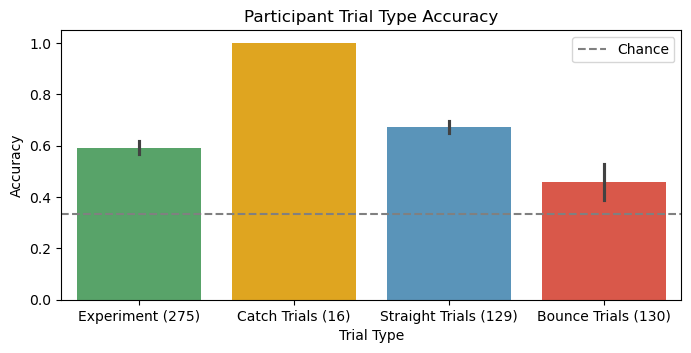

In [348]:
def find_matching_columns(df, desired_patterns):
    # Convert desired patterns to lower case for case insensitive matching
    desired_patterns = [pattern.lower() for pattern in desired_patterns]
    
    # Convert DataFrame column names to lower case
    lower_case_columns = {col.lower(): col for col in df.columns}

    # List to collect matching column names in order
    matching_columns = []
    
    # Check for matches in the order of the input patterns
    for pattern in desired_patterns:
        matches = [orig_col for lc_col, orig_col in lower_case_columns.items() if fnmatch.fnmatchcase(lc_col, pattern)]
        matching_columns.extend(matches)

    return list(matching_columns)
    
columns_to_plot = find_matching_columns(
    df_stats_all_participants,
    [
        "Accuracy Experiment*",
        "Accuracy Catch Trials*",
        "Accuracy Straight Trials*",
        "Accuracy Bounce Trials*",
    ],
)

# Melt the DataFrame to long format
df_stats_all_participants_melted = df_stats_all_participants[columns_to_plot].melt(var_name='Column', value_name='Value')

shortened_columns_to_plot = {col: " ".join(col.split(" ")[1:]) for col in columns_to_plot}
df_stats_all_participants_melted["Column"] = df_stats_all_participants_melted["Column"].map(
    shortened_columns_to_plot
)

palette = get_color_palette(
    [shortened_columns_to_plot[col] for col in columns_to_plot],
    {
        "Greens": 1,
        "Wistia" : 1,
        "Blues" : 1,
        "Reds" : 1,
    },
    linspace_range=(0.6, 1),
)

# Create the swarm plot
plt.figure(figsize=(8, 3.5))
sns.barplot(
    x="Column",
    y="Value",
    hue="Column",
    data=df_stats_all_participants_melted,
    palette=palette,
    errorbar="se",
)
plt.title('Participant Trial Type Accuracy')
plt.xlabel('Trial Type')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
plt.axhline(y=1/3, color='gray', linestyle='--', label="Chance")
plt.legend()
plt.show()

### Entered Color vs Next Color Prediction Differences

In [349]:
# Only Compute these for straight and bounce trials
analysis_trial_types = ["straight", "bounce"]
dict_df_metadata_trial_types_analysis = {
    trial_type : dict_df_metadata_trial_types[trial_type]
    for trial_type in analysis_trial_types 
}

# Convenience
all_participant_responses_experiment = {
    participant_id : participant_data["responses"]["experiment"]
    for participant_id, participant_data in all_participant_data.items()
}

In [356]:
# Get counts for which color participants predicted relative to what color it
# entered the grayzone as
color_counts_trial_type = {}

for trial_type, df_metadata_trial_type in dict_df_metadata_trial_types_analysis.items():
    color_counts_trial_type[trial_type] = {}

    for participant_id, participant_data in all_participant_data.items():
        # Filter for this trial type
        responses_trial_type = filter_participant_data(
            participant_data["responses"]["experiment"], 
            df_metadata_trial_type,
        )

        # If they missed a trial then we need to change the color comparison
        if len(participant_data["responses"]["missed"]):
            df_comparison = filter_participant_data(
                df_metadata_trial_type,
                responses_trial_type,
            )
        else:
            df_comparison = df_metadata_trial_type

        # Need one of the comparitors to be values
        responses = responses_trial_type.response.values

        # Compare to the different color options
        match_entered = (responses == df_comparison.color_entered).mean()
        match_next = (responses == df_comparison.color_next).mean()
        match_after_next = (responses == df_comparison.color_after_next).mean()

        color_counts_trial_type[trial_type][participant_id] = {
            "Color Entered": match_entered,
            "Next Color" : match_next,
            "Third Color": match_after_next,
        }
color_counts_trial_type

{'straight': {'ac2787': {'Color Entered': np.float64(0.5658914728682171),
   'Next Color': np.float64(0.3875968992248062),
   'Third Color': np.float64(0.046511627906976744)},
  '44b303': {'Color Entered': np.float64(0.937984496124031),
   'Next Color': np.float64(0.023255813953488372),
   'Third Color': np.float64(0.03875968992248062)},
  'efa633': {'Color Entered': np.float64(0.7364341085271318),
   'Next Color': np.float64(0.24806201550387597),
   'Third Color': np.float64(0.015503875968992248)}},
 'bounce': {'ac2787': {'Color Entered': np.float64(0.23076923076923078),
   'Next Color': np.float64(0.6076923076923076),
   'Third Color': np.float64(0.15384615384615385)},
  '44b303': {'Color Entered': np.float64(0.9307692307692308),
   'Next Color': np.float64(0.03076923076923077),
   'Third Color': np.float64(0.038461538461538464)},
  'efa633': {'Color Entered': np.float64(0.4153846153846154),
   'Next Color': np.float64(0.5461538461538461),
   'Third Color': np.float64(0.0384615384615

In [372]:
# Flatten the nested dictionary
records = []
for trial_type, participants in color_counts_trial_type.items():
    for participant_id, color_predictions in participants.items():
        for color, count in color_predictions.items():
            records.append(
                {
                    'Trial Type': trial_type.title(), 
                    'Participant ID': participant_id,
                    'Color Prediction': color,
                    'Count': count,
                }
            )

# Convert the list of records to a DataFrame
df_color_counts_trial_type = pd.DataFrame(records)
df_color_counts_trial_type.head()

,Trial Type,Participant ID,Color Prediction,Count
0,Straight,ac2787,Color Entered,0.565891
1,Straight,ac2787,Next Color,0.387597
2,Straight,ac2787,Third Color,0.046512
3,Straight,44b303,Color Entered,0.937984
4,Straight,44b303,Next Color,0.023256


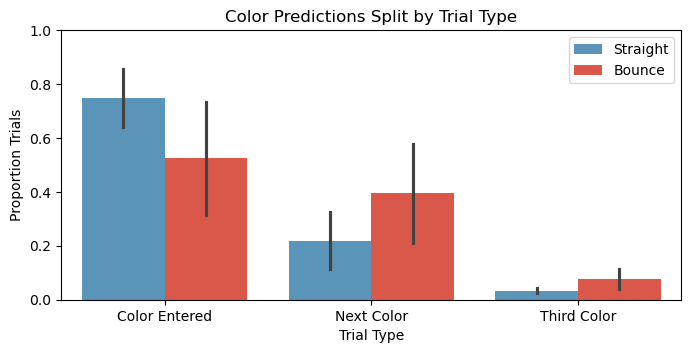

In [373]:
palette = get_color_palette(
    ["Straight", "Bounce"],
    {
        "Blues" : 1,
        "Reds" : 1,
    },
    linspace_range=(0.6, 1),
)

plt.figure(figsize=(8, 3.5))
sns.barplot(
    x="Color Prediction",
    y="Count",
    hue="Trial Type",
    data=df_color_counts_trial_type,
    palette=palette,
    errorbar="se",
)
plt.title('Color Predictions Split by Trial Type')
plt.xlabel('Trial Type')
plt.ylabel('Proportion Trials')
plt.ylim(0, 1.0)
plt.legend()
plt.show()

## Distinguish Hazard Rates?

## Distinguish Contingencies?

## How Does Accuracy Change?

## How Does Response Time Change?